# Dynamic optimization

## Init

-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf40lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf50lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf60lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf70lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf80lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf85lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf90lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf93lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf96lg_AVC.mp4
-assessed= tests_vids/OPT_vids/lg_dist/big_buck__vmaf98lg_AVC.mp4
[ 131902.  153260.  192776.  256143.  374355.  479178.  689658.  959575.
 1574398. 3573955.]
[33.838836 42.357782 51.187629 60.282139 68.738373 73.536076 78.030427
 80.46304  82.940803 84.475781]
-assessed= tests_vids/OPT_vids/cf_dist/big_buck__vmaf40cf_AVC.mp4
-assessed= tests_vids/OPT_vids/cf_dist/big_buck__vmaf50cf_AVC.mp4
-assessed= t

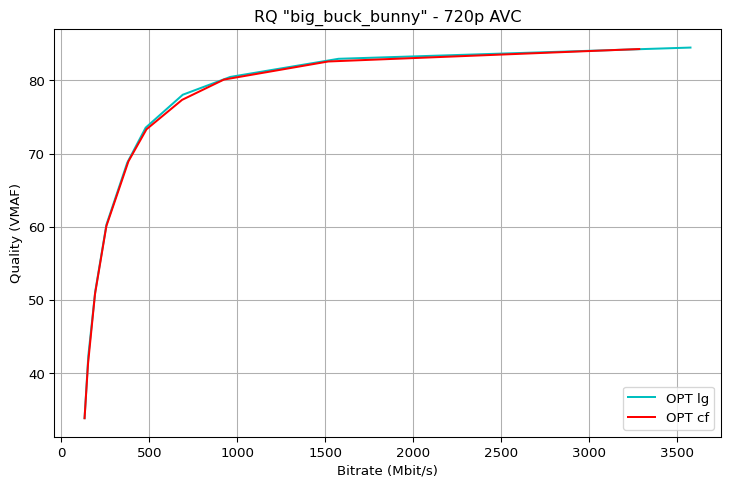

<Figure size 432x288 with 0 Axes>

In [3]:
# imports
import os #to access system folders
import sys #to exit the process
import subprocess #to access ffmpeg in the system
import shutil #to remove directories
import numpy as np #easy vector operations
import math #for operation with infinite
import itertools #to combine options
import copy #to create list shadow copies
from scipy.optimize import curve_fit #to fit points along a curve
import json #to handle json files
import matplotlib.pyplot as pl #to display plots
import tkinter as tk #to import files
from tkinter import filedialog #to open import dialog box

def print_info(file):
    command = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {file}"
    cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
    jout = json.loads(cout)
    print(jout)
            
def get_bitrate(file):
    command = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {file}"
    cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
    jout = json.loads(cout)  # Convert data from JSON string to dictionary
    return int(jout["format"]["bit_rate"])

def get_vmaf(dist,ref):
    c_vmaf = f"ffmpeg -i {ref} -i {dist} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]scale={res[0]}x{res[1]}:flags=bicubic,setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path=config/vmaf_logs.json:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
    subprocess.call(c_vmaf, shell=True)
    print("-assessed= " + dist)
    with open("config/vmaf_logs.json", 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    return i_data["pooled_metrics"]["vmaf"]["mean"]
    
def scale():
    c_seq = "ffmpeg -i test_vids/srcRAW_FullHD/rush_field_cuts_1080p.y4m \
        -filter:v scale=480x270 test_vids/srcRAW_SD/rush_field_cuts_SDp.y4m"
    subprocess.call(c_seq, shell=True)
    
def open_file():
    root = tk.Tk()
    root.withdraw()
    f = os.path.relpath(filedialog.askopenfilename())
    #file_name = os.path.basename(source_path).split('.')[0]
    return f

res = [1280,720]
#file = "tests_vids/OPT_vids/rush_fiel_vmaf90fx_AVC.mp4"
#file="tests_vids/OPT_vids/rush_fiel_rate1000000fx_AVC.mp4"
f_ref = "tests_vids/srcRAW_HD/big_buck_bunny_720p24.y4m"
#print(get_bitrate(file))
#print(get_vmaf(file,f_ref,res))
#print_info("/home/ubuntu/video_dynopt/tests_vids/srcRAW_4K/Meridian_UHD4k5994_HDR_P3PQ.mp4")
plot = {"PLOT": True, "FX": False, "BF": False, "LG": True, "CF": True, "TARGET": "dist"}

if plot["PLOT"]:
    my_dpi = 96
    pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)

    if plot["FX"]:
        folder = "tests_vids/OPT_vids/fx_"+plot["TARGET"]+"/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-b', label="Fixed CRF")

    if plot["BF"]:
        folder = "tests_vids/OPT_vids/bf_"+plot["TARGET"]+"/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-g', label="OPT bf")

    if plot["LG"]:
        folder = "tests_vids/OPT_vids/lg_"+plot["TARGET"]+"/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-c', label="OPT lg")

    if plot["CF"]:
        folder = "tests_vids/OPT_vids/cf_"+plot["TARGET"]+"/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-r', label="OPT cf")

    pl.grid(True)
    pl.title("RQ \"big_buck_bunny\" - 720p AVC")
    pl.ylabel("Quality (VMAF)")
    pl.xlabel("Bitrate (Mbit/s)")
    pl.legend(loc="lower right")
    pl.figure()

In [1]:
# imports
import os #to access system folders
import sys #to exit the process
import subprocess #to access ffmpeg in the system
import shutil #to remove directories
import numpy as np #easy vector operations
import math #for operation with infinite
import itertools #to combine options
import copy #to create list shadow copies
from scipy.optimize import curve_fit #to fit points along a curve
import json #to handle json files
import matplotlib.pyplot as pl #to display plots
import tkinter as tk #to import files
from tkinter import filedialog #to open import dialog box

with open("config/config.json", 'r') as f:
    config = json.load(f)
    
#encoding paramethers
PARAM_AVC = {"crfs": 52, "opr_range": config["ENC"]["CRF_RANGE"], "lib": "libx264", "container": "mp4", "add_param": ""}
PARAM_HEVC = {"crfs": 52, "opr_range": config["ENC"]["CRF_RANGE"], "lib": "libx265", "container": "mp4", "add_param": ""}
PARAM_VP9 = {"crfs": 64, "opr_range": config["ENC"]["CRF_RANGE"], "lib": "libvpx-vp9", "container": "webm", "add_param": "-b:v 0"}
num_intvl = config["ENC"]["NUM_INTERVALS"] 

codec = config["ENC"]["CODEC"] 
raw_width = config["ENC"]["WIDTH"]
raw_height = config["ENC"]["HEIGHT"]
raw_fps = config["ENC"]["FPS"]
target_list = {"dist": config["OPT"]["DIST_TARGETS"], "rate": config["OPT"]["RATE_TARGETS"]}
dist_metric = config["OPT"]["DIST_METRIC"]
opt_type = config["OPT"]["OPT_METHOD"]

#input file
root = tk.Tk()
root.withdraw()
source_path = os.path.relpath(filedialog.askopenfilename())
source_name = os.path.basename(source_path).split('.')[0]
REF_PATH = config["DIR"]["REF_PATH"] #raw files for each shot
[os.remove(REF_PATH+f) for f in os.listdir(REF_PATH)] #clean temp_refs folder
DIST_PATH = config["DIR"]["DIST_PATH"] #encoded files for each shot
[shutil.rmtree(DIST_PATH+f) for f in os.listdir(DIST_PATH)] #clean temp_encoded folder

#assessment files path
tm_file = "config/" + "template.json"
rd_file = "tests_rd/" + source_name + ".json"
if not os.path.isfile(rd_file): #if file does not exists create it
    with open(rd_file, 'w') as f:
        pass
VMAF_LOGS = "config/" + config["DIR"]["VMAF_LOGS"]

#shot detection
TIME_LOGS = "config/" + config["DIR"]["TIME_LOGS"]
shot_th = config["OPT"]["SHOT_DETECT_TH"] #change shot threshold
num_scenes = 0
duration = 0.0

#output file
OUT_LIST = "config/" + config["DIR"]["OUT_LIST"]
OUT_PATH = config["DIR"]["OUT_PATH"]

#all computed points, by row: crf, bitrate and distortion metric
str_matrix = {"crf": None, "rate": None, "dist": None}

print("-init done")

-init done


## Shot change detection

In [2]:
#an empty json structure is generated to be filled and to store computed values
def init_res_matrix(x):
    str_matrix["crf"] = np.zeros(x, dtype=int).tolist()
    str_matrix["rate"] = np.zeros(x, dtype=int).tolist()
    str_matrix["dist"] = np.zeros(x).tolist()
    
#detect shot changes in the scene and split it into shots
def shot_change_detection(p):
    start_t = 0.0
    end_t = 0.0
    global duration
    #return when the shot changes
    det = f"ffmpeg -i {p} -filter_complex:v \"select='gt(scene,{shot_th})', \
        metadata=print:file={TIME_LOGS}\" -f null -"
    subprocess.call(det, shell=True)
    #get the total duration for the last cut
    idu = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {p}"
    dta = json.loads(subprocess.run(idu.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout)
    duration = float(dta['format']['duration'])
    
    with open(TIME_LOGS, 'r') as r:
        tm_log = r.read().splitlines()[::2]
    tm_log.append("end pts_time:" + str(duration))
    n = len(tm_log)
    for i,l in enumerate(tm_log): #for each cut
        #create a folder for each scene
        new_dir = str(i)
        new_path = os.path.join(DIST_PATH, new_dir)
        os.mkdir(new_path)
        
        #cut the video
        end_t = l.split("pts_time:",1)[1]
        cut = f"ffmpeg -ss {start_t} -to {end_t} -i {p} \
            -pix_fmt yuv420p {REF_PATH}scene{str(i).zfill(7)}.yuv"
        subprocess.call(cut, shell=True)
        start_t = end_t
    return n

In [3]:
struct_points = [] #structure of target points for the json file
struct_shots = [] #structure of shots for the json file

if source_path.endswith(".yuv"):
    print("yuv input")
elif source_path.endswith(".y4m"):
    print("y4m input")
else:
    print("Not such an input type")
    sys.exit()

num_scenes = shot_change_detection(source_path)
    
#init values based on the selected output codec
if codec == "avc":
    s_cod = PARAM_AVC
    init_res_matrix(PARAM_AVC["crfs"])
elif codec == "hevc":
    s_cod = PARAM_HEVC
    init_res_matrix(PARAM_HEVC["crfs"])
elif codec == "vp9":
    s_cod = PARAM_VP9
    init_res_matrix(PARAM_VP9["crfs"])
else:
    print("Not such a codec")
    sys.exit()

if num_intvl > s_cod["opr_range"][1] - s_cod["opr_range"][0]:
    print("ERROR: too many encodings")
    sys.exit()

with open(tm_file, 'r') as f:
    o_data = json.load(f)
    
#add source name and results matrix
o_data["content"] = source_name
o_data["codec"] = codec
o_data["width"] = raw_width
o_data["height"] = raw_height
o_data["fps"] = raw_fps
o_data["shots"][0]["assessment"] = str_matrix
    
#add emplty target points
base_point = o_data["shots"][0]["opt_points"][0]
for t_name in target_list:
    for t_val in target_list[t_name]:
        base_point["metric"] = t_name
        base_point["target"] = t_val
        struct_points.append(copy.deepcopy(base_point))
o_data["shots"][0]["opt_points"] = struct_points
    
#add empty shots
base_shot = o_data["shots"][0]
for i in range(0, num_scenes):
    base_shot["index"] = i #assign index to shots in json file
    struct_shots.append(copy.deepcopy(base_shot))
o_data["shots"] = struct_shots

with open(rd_file, 'w') as w:
    json.dump(o_data, w, separators=(',',': '))
    
if dist_metric == "vmaf":
    target_list["dist"] = 100 - np.asarray(target_list["dist"])
elif dist_metric == "psnr":
    print("not yet implemented")
    #TODO normalize psnr and set a max
    sys.exit()
else:
    print("ERROR - not a target")
    sys.exit()

y4m input


ffmpeg version N-106635-g83e1a1de88 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/home/ubuntu/ffmpeg_build --pkg-config-flags=--static --extra-cflags=-I/home/ubuntu/ffmpeg_build/include --extra-ldflags=-L/home/ubuntu/ffmpeg_build/lib --extra-libs='-lpthread -lm' --ld=g++ --bindir=/home/ubuntu/bin --enable-gpl --enable-gnutls --enable-libaom --enable-libass --enable-libfdk-aac --enable-libfreetype --enable-libmp3lame --enable-libopus --enable-libsvtav1 --enable-libdav1d --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libvmaf --enable-version3 --enable-nonfree
  libavutil      57. 24.101 / 57. 24.101
  libavcodec     59. 26.100 / 59. 26.100
  libavformat    59. 22.100 / 59. 22.100
  libavdevice    59.  6.100 / 59.  6.100
  libavfilter     8. 33.100 /  8. 33.100
  libswscale      6.  6.100 /  6.  6.100
  libswresample   4.  6.100 /  4.  6.100
  libpostproc    56.  5.100 / 56.  5.100

## Optimization
Find the shot encoded to a certain crf that has the closest quality or rate to the target

In [4]:
def encode(s,i,c):
    add_info = s_cod["add_param"]
    lib = s_cod["lib"]
    o = DIST_PATH + str(i) + "/" + str(c) + "_" + codec.upper() + "." + s_cod["container"]
    enc = f"ffmpeg -f rawvideo -video_size {raw_width}x{raw_height} -r {raw_fps} \
        -pixel_format yuv420p -i {REF_PATH + s} -c:v {lib} -crf {c} {add_info} {o} -hide_banner -loglevel error"
    subprocess.call(enc, shell=True)
    print("-encoded= " + o)
    return o

def assess(s,o):
    c_vmaf = f"ffmpeg -f rawvideo -r {raw_fps} -video_size {raw_width}x{raw_height} -i {REF_PATH + s} \
            -i {o} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]scale={raw_width}x{raw_height}:flags=bicubic, setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path={VMAF_LOGS}:log_fmt=json\" \
            -f null -"
    subprocess.call(c_vmaf, shell=True)

#store the quality and rate results for each shot at each encoded crf
def store_results(i,c,o):
    with open(VMAF_LOGS, 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    o_data["shots"][i]["assessment"]["crf"][c] = c
    o_data["shots"][i]["assessment"]["dist"][c] = i_data["pooled_metrics"]["vmaf"]["mean"]
    #o_data["shots"][i]["assessment"]["psnr"][c] = (6*i_data["pooled_metrics"]["psnr_y"]["mean"] + \
        #i_data["pooled_metrics"]["psnr_cb"]["mean"] + i_data["pooled_metrics"]["psnr_cr"]["mean"])/8
    info = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {o}"
    cout = json.loads(subprocess.run(info.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout)
    o_data["shots"][i]["assessment"]["rate"][c] = int(cout["format"]["bit_rate"])
    o_data["shots"][i]["duration"] = float(cout["format"]["duration"])

#store final results aslo in the json file
def save_opt(i, t, opt):
    o_data["shots"][i]["opt_points"][t]["crf"] = int(opt)
    with open(rd_file, 'w') as w:
        json.dump(o_data, w, separators=(',',': '))

#linear interpolation of the target and the weight alpha between sx and dx
def interpolate(sx, dx, t):
    alpha = (res_matrix[t_name][sx] - t) / (res_matrix[t_name][sx] - res_matrix[t_name][dx])
    new_point = round(res_matrix["crf"][sx] - alpha * (res_matrix["crf"][sx] - res_matrix["crf"][dx]))
    return new_point

#create all encoded points possible combinations and find the closest to the target
def combine():
    o = []
    if t_name == "dist":
        y_min = math.inf
        to_min = "rate"
        xf, xg, yf, yg = 100, 1, 0, -1
    elif t_name == "rate":
        y_min = 100
        to_min = "dist"
        xf, xg, yf, yg = 0, -1, 100, 1
    for comb in itertools.product(*s_crfs): #for each combination
        x = y = 0
        for i,val in enumerate(comb):
            x += (xf-xg*o_data["shots"][i]["assessment"][t_name][val]) * o_data["shots"][i]["duration"]
            y += (yf-yg*o_data["shots"][i]["assessment"][to_min][val]) * o_data["shots"][i]["duration"]
        x = x / duration
        y = y / duration
        if x < t_val and y < y_min:
            y_min = y
            o = list(comb)
            x_min = x
    if not o:
        o = list(comb)
    return o

#slope value between two points
def compute_slope(xl,yl,xr,yr):
    return -(yl-yr)/(xl-xr)

#split an interval (l[0],l[1]) into n values
def interval(l,n):
    w = (l[1] - l[0]) / (n - 1)
    return np.array([round(l[0]+i*w) for i in range(n)])
        
def as_fit(x, a, b, c): #curve y=1/x
    return a / (x + b) + c

def check_side(s):
    m = -t_ext["slope"]
    count = 1
    while count > 0:
        l0 = [(m*t_pts["rate"][s][s_mins[s]] - t_pts["dist"][s][s_mins[s]])/m,0]
        l1 = [0,t_pts["dist"][s][s_mins[s]] - m*t_pts["rate"][s][s_mins[s]]]
        count = 0
        for i in range(0, len(t_pts["dist"][s])):
            py = t_pts["dist"][s][i]
            px = t_pts["rate"][s][i]
            crss = (l1[0] - l0[0])*(py - l0[1]) - (px - l0[0])*(l1[1] - l0[1])
            if crss > 0.1:
                s_mins[s] = i
                count += 1
    return s_mins[s]

In [5]:
target_index = 0
step_index = 0
for t_name in target_list:
    for t_val in target_list[t_name]:
        
        if opt_type == "fx": #fixed CRF
            npts = interval(s_cod["opr_range"], num_intvl).tolist()
            s_pts = {"rate": np.zeros((num_scenes, len(npts))), \
                        "dist": np.zeros((num_scenes, len(npts)))}
            t_pts = {"rate": np.zeros(len(npts)), \
                        "dist": np.zeros(len(npts))}
            shot_index = 0
            if target_index == 0:
                for shot in sorted(os.listdir(REF_PATH)): #for each shot
                    print(shot)
                    for val_crf in npts:
                        out = encode(shot, shot_index, val_crf) #encoding
                        assess(shot, out) #quality assessment
                        store_results(shot_index, val_crf, out)
                        r = o_data["shots"][shot_index]["assessment"]["rate"][val_crf]
                        d = 100 - o_data["shots"][shot_index]["assessment"]["dist"][val_crf]
                        s_pts["rate"][shot_index][n_crf] = r * o_data["shots"][shot_index]["duration"] / duration
                        s_pts["dist"][shot_index][n_crf] = d * o_data["shots"][shot_index]["duration"] / duration
                t_pts["rate"][pt] = np.einsum('ij->j',s_pts["rate"]) #sum rate results per crf
                t_pts["dist"][pt] = np.einsum('ij->j',s_pts["dist"]) #sum dist results per crf
            n_crf = 0
            while t_pts[t_name][n_crf] < t_val:
                curr_crf = npts[n_crf]
                n_crf += 1
            print("--out_crf= " + str(curr_crf))
            for i in range(0,num_scenes): #save the opt crf for each shot
                save_opt(i, target_index, curr_crf)
        
        elif opt_type == "bf": #brute force approach
            shot_index = 0
            if target_index == 0:
                npts = interval(s_cod["opr_range"], num_intvl).tolist()
                s_crfs = np.zeros((num_scenes, len(npts)), dtype=int) #init structure
                for shot in sorted(os.listdir(REF_PATH)): #for each shot
                    for current_crf in npts:
                        out = encode(shot, shot_index, current_crf) #encoding
                        assess(shot, out) #quality assessment
                        store_results(shot_index, current_crf, out)
                    s_crfs[shot_index] = [c for c in o_data["shots"][shot_index]["assessment"]["crf"] if c != 0] #take only encoded shots
                    shot_index += 1
            opt_crfs = combine() #create all combinations
            print("--out_crfs= " + str(opt_crfs))
            for i in range(0,num_scenes): #save the opt crf for each shot
                save_opt(i, target_index, opt_crfs[i])
            
        elif opt_type == "lg": #lagrangian optimization
            curr_opt = {"l": np.zeros(num_scenes), "r": np.zeros(num_scenes)} #new optimal inteval bounds
            prev_opt = {"l": np.ones(num_scenes), "r": np.ones(num_scenes)} #previous optimal inteval bounds
            s_pts = {"crf": np.zeros(num_scenes, dtype=int), \
                        "rate": np.zeros(num_scenes), \
                        "dist": np.zeros(num_scenes)} #info current optimal combination
            t_ext = {"l": [], "r": [], "slope": 0.0} #general slope
            
            if target_index == 0:
                t_pts = {"crf": interval(s_cod["opr_range"], num_intvl), \
                            "rate": np.zeros((num_scenes, num_intvl)), \
                            "dist": np.zeros((num_scenes, num_intvl))} #info encoded shots
                s_slopes = np.zeros((num_scenes, num_intvl - 1)) #single slopes
                shot_index = 0
                for shot in sorted(os.listdir(REF_PATH)): #for each shot
                    for n_crf, val_crf in enumerate(t_pts["crf"]): #for each init crf
                        out = encode(shot, shot_index, val_crf) #encoding
                        assess(shot, out) #quality assessment
                        store_results(shot_index, int(val_crf), out)
                        #store results in t_pts dictionary, weighted by duration
                        r = o_data["shots"][shot_index]["assessment"]["rate"][val_crf]
                        d = 100 - o_data["shots"][shot_index]["assessment"]["dist"][val_crf]
                        t_pts["rate"][shot_index][n_crf] = r * o_data["shots"][shot_index]["duration"] / duration
                        t_pts["dist"][shot_index][n_crf] = d * o_data["shots"][shot_index]["duration"] / duration
                    for n_crf in range(1,num_intvl): #compute and store slope between all close points
                        s_slopes[shot_index][n_crf-1] = compute_slope(t_pts["rate"][shot_index][n_crf],\
                                                                      t_pts["dist"][shot_index][n_crf],\
                                                                      t_pts["rate"][shot_index][n_crf-1],\
                                                                      t_pts["dist"][shot_index][n_crf-1])
                    shot_index += 1
            t_rate = np.einsum('ij->j',t_pts["rate"]) #sum rate results per crf
            t_dist = np.einsum('ij->j',t_pts["dist"]) #sum dist results per crf
            t_ext["l"] = [t_rate[-1], t_dist[-1]] #last element, crfs 51
            t_ext["r"] = [t_rate[0], t_dist[0]] #first element, crfs 0
            t_ext["slope"] = compute_slope(t_ext["l"][0],t_ext["l"][1],t_ext["r"][0],t_ext["r"][1])
            
            #when new solution is the same as the past one
            while not (curr_opt["r"] == prev_opt["r"]).all() or not (curr_opt["l"] == prev_opt["l"]).all():
                prev_opt = curr_opt.copy() #keep track of the previous optimal combination
                diffs = abs(s_slopes - t_ext["slope"]) #difference between all and current slope
                s_mins = np.argmin(diffs, axis=1) #find the min difference
                for shot in range(0,num_scenes):
                    s_curr = check_side(shot)
                    s_pts["crf"][shot] = t_pts["crf"][s_curr]
                    s_pts["rate"][shot] = t_pts["rate"][shot][s_curr]
                    s_pts["dist"][shot] = t_pts["dist"][shot][s_curr]
                t_rate = np.einsum('i->',s_pts["rate"]) #sum rate results per crf
                t_dist = np.einsum('i->',s_pts["dist"]) #sum dist results per crf
                if np.einsum('i->',s_pts[t_name]) > t_val: #if current opt go beyond the target
                    if t_name == "dist":
                        t_ext["l"] = [t_rate, t_dist] #new general point
                        curr_opt["l"] = s_pts["crf"].copy()
                    elif t_name == "rate":
                        t_ext["r"] = [t_rate, t_dist]
                        curr_opt["r"] = s_pts["crf"].copy()
                else:
                    if t_name == "dist":
                        t_ext["r"] = [t_rate, t_dist] #new general point
                        curr_opt["r"] = s_pts["crf"].copy()
                    elif t_name == "rate":
                        t_ext["l"] = [t_rate, t_dist]
                        curr_opt["l"] = s_pts["crf"].copy()
                t_ext["slope"] = compute_slope(t_ext["l"][0],t_ext["l"][1],t_ext["r"][0],t_ext["r"][1])
                step_index += 1
                
            if t_name == "dist":
                print("--out_crfs= " + str(curr_opt["r"]))
                for i in range(0,num_scenes): #save the opt crf for each shot
                    save_opt(i, target_index, curr_opt["r"][i])
            elif t_name == "rate":
                print("--out_crfs= " + str(curr_opt["l"]))
                for i in range(0,num_scenes):
                    save_opt(i, target_index, curr_opt["l"][i])
        
        
        elif opt_type == "cf": #curve fitting
            num_init_pts = 5 #more for more precision
            init_pts = {"crf": interval(s_cod["opr_range"], num_init_pts), \
                        "rate": np.zeros((num_init_pts, num_scenes)), \
                        "dist": np.zeros((num_init_pts, num_scenes))} #info first encoded shots
            shot_index = 0
            for shot in sorted(os.listdir(REF_PATH)): #for each shot
                for i, current_crf in enumerate(init_pts["crf"]): #for each init crf
                    out = encode(shot, shot_index, current_crf) #encoding
                    assess(shot, out) #quality assessment
                    store_results(shot_index, current_crf, out)
                    #store results in the dictionary, weighted by duration
                    r = o_data["shots"][shot_index]["assessment"]["rate"][current_crf]
                    d = 100 - o_data["shots"][shot_index]["assessment"]["vmaf"][current_crf]
                    init_pts["rate"][i][shot_index] = r * o_data["shots"][shot_index]["duration"] / duration
                    init_pts["dist"][i][shot_index] = d * o_data["shots"][shot_index]["duration"] / duration
                shot_index += 1
            #sum results per crf number and find the starting interval
            init_pts["rate"] = np.einsum('ij->i',init_pts["rate"])
            init_pts["dist"] = np.einsum('ij->i',init_pts["dist"])
            t_ext = {"l": [init_pts["rate"][b-1], init_pts["dist"][b-1]], \
                     "r": [init_pts["rate"][b], init_pts["dist"][b]], "slope": 0.0}
            t_ext["slope"] = compute_slope(t_ext["l"][0],t_ext["l"][1],t_ext["r"][0],t_ext["r"][1])
            
            while point_index == 0:
                shot_index = 0
                #if shot_index == 0: #CHANGE for each shot
                for shot in sorted(os.listdir(REF_PATH)):
                    rates = [x for x in o_data["shots"][shot_index]["assessment"]["rate"] if x != 0]
                    dists = np.asarray([y for y in o_data["shots"][shot_index]["assessment"]["dist"] if y != 0])
                    shot_index += 1
                point_index = 1
                print(rates)
                print(dists)
                
        else:
            print("ERROR - not an opt method")
            sys.exit()
        target_index += 1

scene0000000.yuv
-encoded= tests_vids/temp_encoded/0/10_AVC.mp4


NameError: name 'n_crf' is not defined

## Mux opt video
Muxing of the all single optimal encoded shots

In [ ]:
def mux(t_i, t_name, t_val):
    file_list = "" #list of encoded vids to be stored in OUT_LIST
    with open(rd_file, 'r') as f:
        o_data = json.load(f)
    for shot in range(0,num_scenes):
        opt_crf = o_data["shots"][shot]["opt_points"][t_i]["crf"]
        file_list = file_list + "file '" + DIST_PATH + str(shot) + "/" \
        + str(opt_crf) + "_" + codec.upper() + "." + s_cod["container"] + "' \n"
    with open(OUT_LIST, 'w') as w:
        w.write(file_list)
    o = OUT_PATH+source_name[:9] + "_" + t_name + str(t_val) + opt_type +\
        "_" + codec.upper() + "." + s_cod["container"]
    mux = f"ffmpeg -f concat -i {OUT_LIST} -c copy {o}"
    subprocess.call(mux, shell=True)

In [ ]:
target_index = 0
if dist_metric == "vmaf":
    target_list["dist"] = 100 - np.asarray(target_list["dist"])
for t_name in target_list:
    for t_val in target_list[t_name]:
        if t_name == "dist":
            t_name = dist_metric
        mux(target_index, t_name, t_val)
        target_index += 1